# Introduction

Key takeaways
* Installing packages
* Handling data with pandas
* Unzipping Files with Python
* Using seaborn for vizualization
* Using matplotlib for vizualization
* Creating Lambda functions
* Deploying machine learning models
* Evaluating machine learning results
* Validating aggregates

# The CRISP-DM Process

For this project, I will be following the CRISP-DM (Cross-industry standard process for data mining) process.

![alt text](https://codesachin.files.wordpress.com/2015/09/crisp-dm.gif)
The process follows these steps:
    1. Pick a dataset
    2. Generate business questions
    3. Obtain data understanding
    4. Prepare the data
    5. Analyze, Model, and Visualize
    6. Evaluate your analysis
    7. Communicate business insights   
 
 
    
This project approaches these steps in the following way:
    1. Boston & Seattle Airbnb Open Data 
    2. I am starting with these business questions.
        a. What is the mission of Airbnb?
        b. What is more likely to cause bad reviews?
        c. What is the cost of bad reviews?
        d. What is the value of good reviews?
    3. Steps 3 to 6 will be conducted using a Jupyter notebook, and some Python 3 magic!

##### Analysis Information:

During the analysis there will be explenations about extract null analysis, imputations, egnineered features, correlation status, and removal decision.
Look for the followings:
* Extract null analysis for **dataset**
* Imputation decision for **feature name**
* Engineering decision for **feature name**
* Correlation status for **feature name**
* Removal decision for **columns or rows**


# Data Handling

## Imports

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
from helper import Tracker
from helper import unzip_files, read_concat
from helper import cleaning_dollar
%matplotlib inline
plt.style.use('ggplot')

## Trackers

In [4]:
# Feature tracker lists
predictors = []
possible = []
dummies = []
irrelevant = []
all_assessed = []
engineered = []

tracker_dict = {'predictors': predictors,
                 'possible': possible,
                 'dummies': dummies,
                 'irrelevant': irrelevant,
                 'all_assessed': all_assessed,
                 'engineered': engineered}

# Instantiating tracker
track = Tracker(tracker_dict)

# Preparing for Extract
---

In [5]:
# getting zip file names
data_zip = os.listdir('data')
data_zip

['boston-airbnb-open-data.zip',
 'boston_airbnb_open_data',
 'extra_seattle',
 'seattle',
 'seattle.zip']

In [6]:
# extracting datasets
folder_names = unzip_files(data_zip)
folder_names

File already extracted!
File already extracted!
File already extracted!


['data\\boston_airbnb_open_data', 'data\\seattle']

In [7]:
[os.listdir(folder_name) for folder_name in folder_names]

[['calendar.csv', 'listings.csv', 'reviews.csv'],
 ['calendar.csv', 'listings.csv', 'reviews.csv']]

# Extracting the Calendar Dataset
---

In [8]:
calendar = read_concat(folder_names, 'calendar.csv')

## Distribution of calendar features

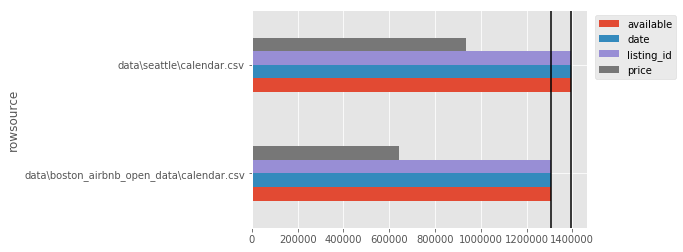

In [9]:
calendar.groupby('rowsource').count().plot.barh();
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left');
for x in calendar.rowsource.value_counts().values:
    plt.vlines(x, -1, 2)

## Calendar Extraction Analysis Results

**Extract null analysis for calendar**:
* We can see that prices are missing.
* All other columns seem completed.

# Extracting the Listings Dataset
---

In [10]:
listings = read_concat(folder_names, 'listings.csv')

## Distribution of listings features

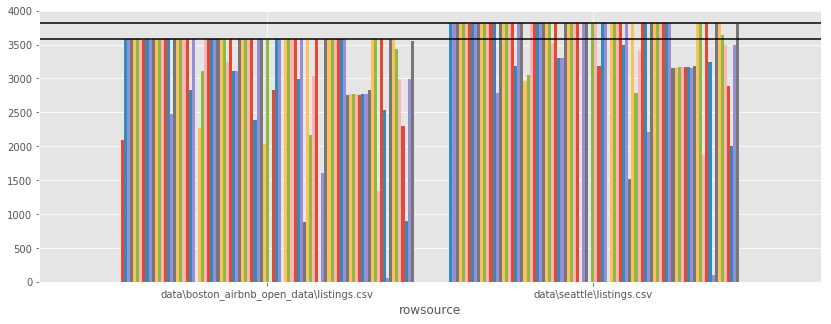

In [11]:
listings\
    .groupby('rowsource')\
    .count()\
    .plot.bar(legend=False, figsize=(14, 5), rot=0, width=.9);
for x in listings.rowsource.value_counts().values:
    plt.hlines(x, -1, 2);

##  Distribution of listings nulls

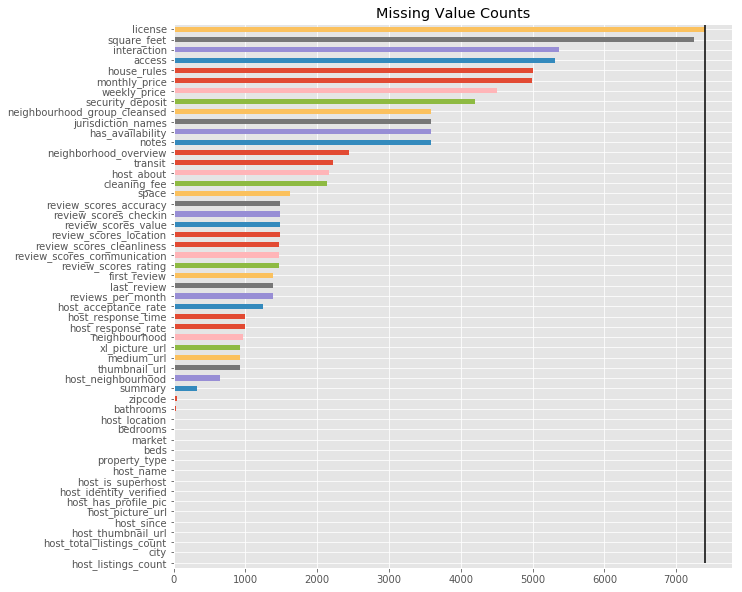

In [12]:
listing_nulls = listings.isnull().sum()\
    .where(lambda x: x>0)\
    .dropna()\
    .sort_values(ascending=True)

listing_nulls\
    .plot.barh(figsize=(10, 10), title="Missing Value Counts");
plt.vlines(listings.shape[0], 100, 0);

##  Distribution of listing nulls by rowsource and bucket null percentages

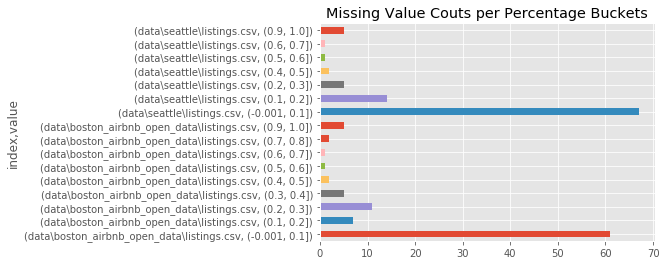

In [13]:
# Total columns by rowsource
totals_byrowsource = listings.rowsource.value_counts()

# Feature totals by rowsource
non_complete_listings = listings.groupby('rowsource').count()

# Feature totals by rowsource - totals, abs
non_complete_listings = non_complete_listings.subtract(totals_byrowsource, axis=0).abs()

# Get percentages of totals per rowsource
non_complete_listings = non_complete_listings.div(totals_byrowsource, axis=0)

# Melt data on rowsource
non_complete_listings = non_complete_listings.reset_index().melt(id_vars='index')

# Grouping by rowsource and provided column buckets
grouping = ['index', pd.cut(non_complete_listings.value, bins=10)]
non_complete_listings = non_complete_listings.groupby(grouping)
non_complete_listings = non_complete_listings.size()
non_complete_listings.plot.barh(title="Missing Value Couts per Percentage Buckets");

In [14]:
listings.isnull().sum().map({0:'Provided'}).fillna('Missing')\
    .to_frame('Status')\
    .groupby('Status')\
    .size()

Status
Missing     53
Provided    43
dtype: int64

## Listings Extraction Analysis Results

**Extract null analysis for listings**:
* We can see that missing values are scattered in this dataset.
* We are investigating these missing values individually and possibly in groups.
* Only 43 column have completed values, 53 of them have missing values.

**Removal decision for listing and square_feet**:
We can see that **license** and **squared_feet** are completely missing or significantly missing. For this reason we are removing these two features from the dataset and not wasting time analyzing them.

## Removing Listings licensce and square_feet

In [15]:
remove_cols = ['license', 'square_feet']
listings.drop(remove_cols, axis=1, inplace=True)

In [16]:
track.add('irrelevant', ['license', 'square_feet'], assessed=True)

In [17]:
track.check()

,all_assessed,predictors,engineered,possible,dummies,irrelevant
0,license,NaN,NaN,NaN,NaN,license
1,square_feet,NaN,NaN,NaN,NaN,square_feet


# Extracting the Reviews Dataset
---

In [18]:
reviews = read_concat(folder_names, 'reviews.csv')

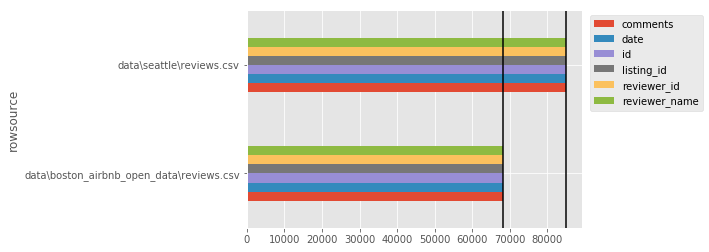

In [19]:
reviews.groupby('rowsource').count().plot.barh();
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left');
for x in reviews.rowsource.value_counts().values:
    plt.vlines(x, -1, 2)

## Reviews Extraction Analysis Results

**Extract null analysis for reviews**:
* reviews are all complete.

# Understanding Calendar

##  First 5 Rows

In [20]:
calendar.head()

,available,date,listing_id,price,rowsource
0,f,2017-09-05,12147973,NaN,data\boston_airbnb_open_data\calendar.csv
1,f,2017-09-04,12147973,NaN,data\boston_airbnb_open_data\calendar.csv
2,f,2017-09-03,12147973,NaN,data\boston_airbnb_open_data\calendar.csv
3,f,2017-09-02,12147973,NaN,data\boston_airbnb_open_data\calendar.csv
4,f,2017-09-01,12147973,NaN,data\boston_airbnb_open_data\calendar.csv


##  Availability Counts

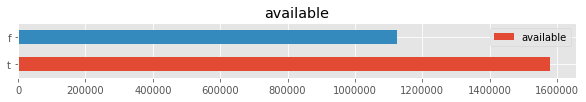

In [21]:
calendar.available.value_counts().plot.barh(
    figsize=(10, 1), title='available', legend=True)

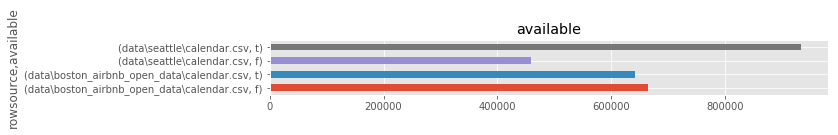

In [22]:
calendar.groupby(['rowsource', 'available']).available.count(
    ).plot.barh(figsize=(10, 1), title='available');

##  Price Formats

In [23]:
calendar.price.str.findall('\D').value_counts().to_frame('price_counts')

,price_counts
"[$, .]",1574314
"[$, ,, .]",3265


### Cleaning Prices

In [24]:
# Cleaning prices
calendar.price = cleaning_dollar(calendar.price)

# Converting date to datetime
calendar.date = pd.to_datetime(calendar.date)

In [25]:
calendar.price.unique()

array([ nan,  65.,  75., ...,  10.,  24., 817.])

## Price Line Trends by Dataset Source

### Price Trend with Filtered Nulls

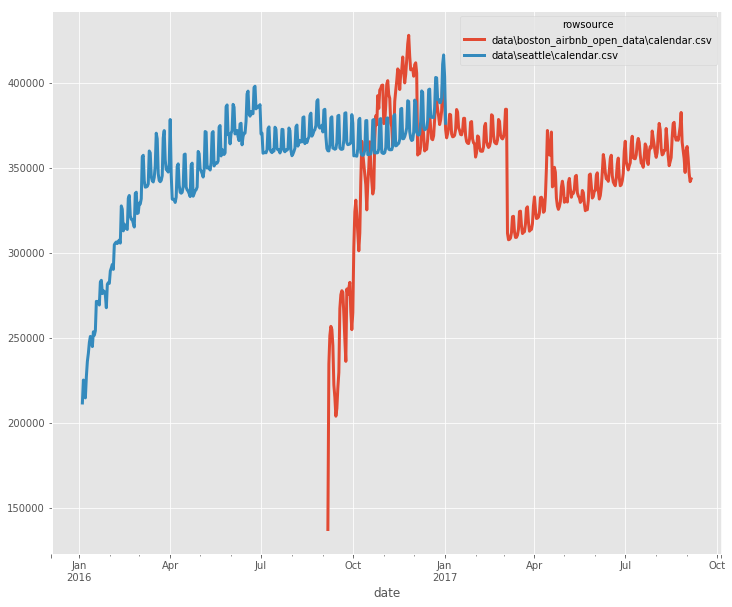

In [26]:
calendar.groupby(['rowsource', 'date'])\
    .agg({'price':'sum'})\
    .reset_index()\
    .pivot(index='date', columns='rowsource', values='price')\
    .plot.line(figsize=(12, 10), lw=3);

### Price Trend with Zeroed Nulls

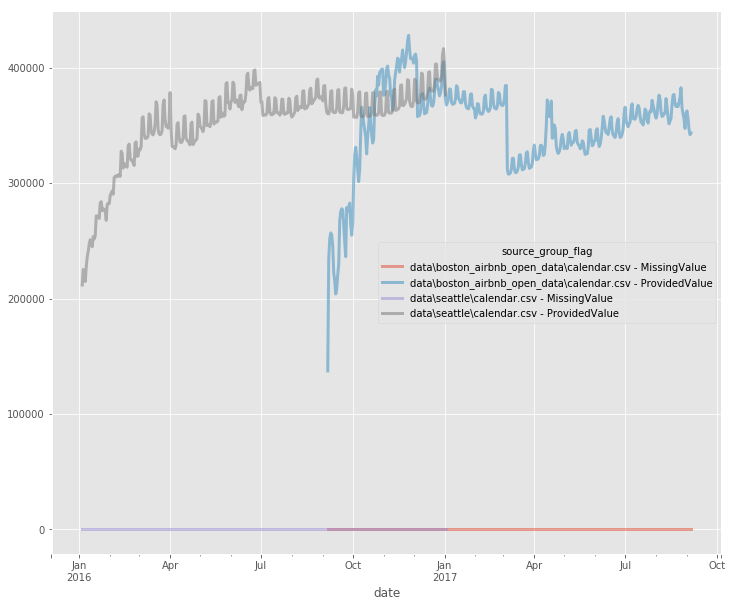

In [27]:
# Grouping missing values and provided values in a flag
calendar['provided_flag'] = calendar.price.fillna('MissingValue')
calendar.loc[calendar.provided_flag!='MissingValue', 'provided_flag'] = 'ProvidedValue'

# Grouping source files with missing values
calendar['source_group_flag'] = calendar.rowsource.str.cat(calendar.provided_flag, sep=' - ')

# Aggregate by source/flag
calendar_grp = calendar.groupby(['source_group_flag', 'date']).agg({'price':'sum'})
calendar_grp = calendar_grp.reset_index()

# Pivot table on source/flag to trend categories
calendar_grp = calendar_grp.pivot(index='date', columns='source_group_flag', values='price')

# Plot
calendar_grp.plot.line(figsize=(12, 10), lw=3, alpha=.5);

## Price Group/Flag Date Ranges

In [28]:
calendar.groupby('source_group_flag').agg({'date': ['min', 'max']})

date           
                                                          min        max
source_group_flag                                                       
data\boston_airbnb_open_data\calendar.csv - Mis... 2016-09-06 2017-09-05
data\boston_airbnb_open_data\calendar.csv - Pro... 2016-09-06 2017-09-05
data\seattle\calendar.csv - MissingValue           2016-01-04 2017-01-02
data\seattle\calendar.csv - ProvidedValue          2016-01-04 2017-01-02

## Difference Between Data Source Pricing Dates

In [29]:
# Month tranformation functions
month_func = lambda x: x.month
delta_month_func = lambda x: x.max_date.shift(1).apply(
    month_func) - x.max_date.apply(month_func)
delta_days_func = lambda x: x.max_date.shift(1) - x.max_date

calendar.groupby('rowsource').agg({
    'date': 'max'
}).rename(columns={
    'date': 'max_date'
}).assign(
    delta_month=delta_month_func, delta_days=delta_days_func).fillna('')

,max_date,delta_month,delta_days
rowsource,,,
data\boston_airbnb_open_data\calendar.csv,2017-09-05,,
data\seattle\calendar.csv,2017-01-02,8,246 days 00:00:00


## Understanding Calendar Results

We can see that there is more availability in Seattle listings. The total monthly trend prices are quite similar for both datasets. And the null values are scattered all within the min and max pricing dates. We are going to investigate these nulls during the listing null analsis.

Dates of datasets do not match. This could mean that these segments where serviced at different times. ARBNB must have started servicing Seattle before Boston. However, Seattle has no data from 2017-01-02 to 2017-09-05, 8 months or 246 days. Therefore, as a warning predictions using Seattle during these ranges will be incorrect. The same applies to Boston where dates do not crossover.

**Transformation**:
* Prices have to be cleaned. They include $ sign and comma separators.

# Understanding Listings
---

## Analyzing Object Features of Listings

In [30]:
# Calculating missing percentages of total listings
missing_pct = listings.isnull().sum() / listings.shape[0]

# Listings examples with missing percentages
pd.options.display.max_rows = 100

listings.select_dtypes(include=object).dropna(
    axis=0, how='all').sample(2).T.merge(
        missing_pct.to_frame('missing'),
        left_index=True,
        right_index=True,
        how='left').iloc[:, [2, 0, 1]].sort_values(
            'missing', ascending=False).style.bar()

,missing,3819,2972
interaction,0.725652,nan,nan
access,0.716872,nan,nan
house_rules,0.676753,nan,nan
monthly_price,0.675132,"$2,500.00",$950.00
weekly_price,0.608132,$720.00,$450.00
security_deposit,0.566662,$150.00,$100.00
jurisdiction_names,0.484263,WASHINGTON,nan
neighbourhood_group_cleansed,0.484263,Queen Anne,nan
has_availability,0.484263,t,nan
notes,0.483723,"Our house has a history! It's over 110 years old, fully remodeled, but it's not a 100% soundproof. The ""old-house"" charm is saved :)) those creaking floorboards and stair treads :)) We (the hosts) live in two top floors of the house, right above the MIL. We have two kids and our dinning table located right above MIL's living room. Occasionally, our guests will hear some of the regular ""family"" noises. Nothing major, just regular household activities, walking and talking. Most likely, the guests won't hear the conversation, but some ""muffed"" voices :)) And, if during the day/dinner time, the guests plan to have fun exploring our beautiful Seattle, then they won't hear us that much :)) It's a typical urban life where we share the space without seeing each other. Please be aware of it and decide on a booking accordingly. Also, this Rental will accommodate 4 people, but it is just perfect cozy size for 2 people. It has one queen size bed and one queen size sofa-sleeper. Please note,",nan


## Understanding Listings Results

## Analying Numeric Features of Listings

In [31]:
listings.filter(regex='id')
listings.select_dtypes(exclude=object).sample(4).T.merge(
    missing_pct.to_frame('missing'),
    left_index=True,
    right_index=True,
    how='left').iloc[:, [-1, 0, 1, 2, 3]].sort_values(
        'missing',
        ascending=False).style.format("{:2,.2f}").bar(subset=['missing'])

,missing,1833,257,766,6213
review_scores_accuracy,0.20,9.00,9.00,10.00,9.00
review_scores_checkin,0.20,9.00,10.00,10.00,10.00
review_scores_value,0.20,9.00,10.00,10.00,7.00
review_scores_location,0.20,10.00,9.00,10.00,9.00
review_scores_cleanliness,0.20,9.00,9.00,10.00,7.00
review_scores_communication,0.20,9.00,10.00,10.00,10.00
review_scores_rating,0.20,91.00,93.00,100.00,72.00
reviews_per_month,0.19,2.24,2.54,1.12,1.28
bathrooms,0.00,1.00,1.00,1.00,1.00
bedrooms,0.00,1.00,1.00,1.00,1.00


## Analyzing Date Features of Listings

In [32]:
listings.select_dtypes(include=object)\
    .apply(pd.to_datetime, errors='ignore')\
    .select_dtypes(include=np.datetime64).head()

,calendar_last_scraped,first_review,host_since,last_review,last_scraped
0,2016-09-06,NaT,2015-04-15,NaT,2016-09-07
1,2016-09-06,2014-06-01,2012-06-07,2016-08-13,2016-09-07
2,2016-09-06,2009-07-19,2009-05-11,2016-08-05,2016-09-07
3,2016-09-06,2016-08-28,2013-04-21,2016-08-28,2016-09-07
4,2016-09-06,2015-08-18,2014-05-11,2016-09-01,2016-09-07


## Understanding Listings Results

We can see that we have to do some imputations on the reviews for the numerical fields. For the object fields there are some numerical values that will have to be cleaned and some irrelevant columns such as urls and names. One thing to notice is that **amenities** and **host_verification** can be split and converted to dummy variables. These could be helpful to the model.

Instead of the scraped_id liking to the calendar dataset, perhaps the **calendar_last_scraped** feature has a meaningful link to the dataset. The other dates could be used to engineer new features except for **last_scraped** since we cannot assume that a relationship between last_scraped and price will be causal in nature.

## Removing last_scraped from Listings

In [33]:
listings.drop('last_scraped', axis=1, inplace=True)

# Uderstanding Reviews

##  Frist 5 Rows

In [34]:
reviews.head()

,comments,date,id,listing_id,reviewer_id,reviewer_name,rowsource
0,My stay at islam's place was really cool! Good...,2013-05-21,4724140,1178162,4298113,Olivier,data\boston_airbnb_open_data\reviews.csv
1,Great location for both airport and city - gre...,2013-05-29,4869189,1178162,6452964,Charlotte,data\boston_airbnb_open_data\reviews.csv
2,We really enjoyed our stay at Islams house. Fr...,2013-06-06,5003196,1178162,6449554,Sebastian,data\boston_airbnb_open_data\reviews.csv
3,The room was nice and clean and so were the co...,2013-06-15,5150351,1178162,2215611,Marine,data\boston_airbnb_open_data\reviews.csv
4,Great location. Just 5 mins walk from the Airp...,2013-06-16,5171140,1178162,6848427,Andrew,data\boston_airbnb_open_data\reviews.csv


## Id Relationships Lenght Box Plots

In [35]:
len_func = lambda x: x.str.len()

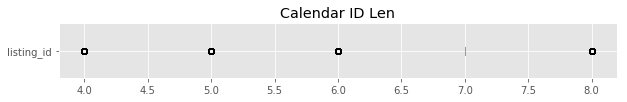

In [36]:
calendar.listing_id.astype(str).str.len()\
    .plot.box(vert=False, figsize=(10, 1), title="Calendar ID Len");

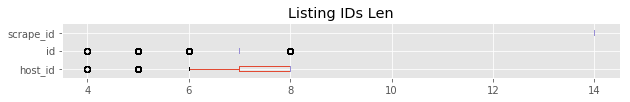

In [37]:
listings.filter(regex='id').select_dtypes(exclude=object).astype(str).apply(len_func)\
    .plot.box(vert=False, figsize=(10, 1), title="Listing IDs Len");

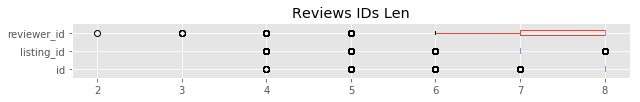

In [38]:
reviews.filter(regex='id').apply(lambda x: x.astype(str).str.len())\
    .plot.box(vert=False, figsize=(10, 1), title="Reviews IDs Len");

## Understanding Reviews Results

We can surely see these are just individual reviews for the listings. Given that there are reviewer-ids with length of 2 and 3 in the reviewers dataset and not in the listings dataset, we can assume that the listings don't include stays (missing records) for those host with 2 and 3 length-ids, but those host have reviews for the listings in the reviewer dataset.

**Findings**:
* The listing dataset id is the primary key that relates to the listing_id of the calendar dataset.
* The scrape_id does not relate to anything in the downloaded dataset, so therefore it is irrelevant for the analysis. However, this id could be related to the calendar date since it could mean that the data was scraped druing a specific calendar date.
* The host_id in the listing dataset seems to be related to the reviewer_id of the reviews dataset.

# Calendar Granularity

## Calendar Duplicates

In [39]:
calendar_dup = calendar.groupby(
    ['date', 'listing_id', 'rowsource',
     'available']).size().to_frame('duplicates').query("duplicates>1")
calendar_dup.head()

,,,,duplicates
date,listing_id,rowsource,available,
2016-09-06,12898806,data\boston_airbnb_open_data\calendar.csv,t,2
2016-09-07,12898806,data\boston_airbnb_open_data\calendar.csv,t,2
2016-09-08,12898806,data\boston_airbnb_open_data\calendar.csv,t,2
2016-09-09,12898806,data\boston_airbnb_open_data\calendar.csv,t,2
2016-09-10,12898806,data\boston_airbnb_open_data\calendar.csv,t,2


In [40]:
calendar_price_dups = calendar_dup.reset_index().listing_id.unique()[0]
print(f"These are the id of price duplicates: \n {calendar_price_dups}")

These are the id of price duplicates: 
 12898806


### Examples of Calendar Duplicates

In [41]:
# Conditions
date_dup = calendar_dup.reset_index().date.astype(str).values.tolist()
date_filter = calendar.date.astype(
    str).apply(lambda x: True if x in date_dup else False)
filter_cond = (calendar.listing_id == 12898806) & date_filter

# Duplicate Examples
calendar.loc[filter_cond, :].sort_values(['date', 'listing_id']).head()

,available,date,listing_id,price,rowsource,provided_flag,source_group_flag
748850,t,2016-09-06,12898806,220.0,data\boston_airbnb_open_data\calendar.csv,ProvidedValue,data\boston_airbnb_open_data\calendar.csv - Pr...
748873,t,2016-09-06,12898806,220.0,data\boston_airbnb_open_data\calendar.csv,ProvidedValue,data\boston_airbnb_open_data\calendar.csv - Pr...
748849,t,2016-09-07,12898806,220.0,data\boston_airbnb_open_data\calendar.csv,ProvidedValue,data\boston_airbnb_open_data\calendar.csv - Pr...
748872,t,2016-09-07,12898806,220.0,data\boston_airbnb_open_data\calendar.csv,ProvidedValue,data\boston_airbnb_open_data\calendar.csv - Pr...
748848,t,2016-09-08,12898806,220.0,data\boston_airbnb_open_data\calendar.csv,ProvidedValue,data\boston_airbnb_open_data\calendar.csv - Pr...


## Calendar Granularity Results

There are 365 duplicates in the calendar dataset. These duplicates can be safely removed since they all share the same information. It does not really matter if we keep the first or last.

The granularity of the table is at the following level:
* Date
* Listing Id

## Removing Calendar Duplicates

In [42]:
# Flag where there are no duplicates
keep_first = ~calendar.duplicated(subset=['date', 'listing_id'], keep='last')

# Remove duplicates by slicing
calendar_clean = calendar[keep_first]

# Calculate the difference beteween sizes
dup_count = calendar_dup.count().values[0]
dup_removed = calendar.shape[0] - calendar_clean.shape[0]

print(f"There where {dup_count} duplicates and {dup_removed} where removed.")

There where 365 duplicates and 365 where removed.


# Listings Granularity

## First 5 Rows

In [43]:
listings.head()

,access,accommodates,amenities,availability_30,availability_365,availability_60,availability_90,bathrooms,bed_type,bedrooms,...,smart_location,space,state,street,summary,thumbnail_url,transit,weekly_price,xl_picture_url,zipcode
0,"You will have access to 2 bedrooms, a living r...",4,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",0,0,0,0,1.5,Real Bed,2.0,...,"Boston, MA",The house has an open and cozy feel at the sam...,MA,"Birch Street, Boston, MA 02131, United States","Cozy, sunny, family home. Master bedroom high...",https://a2.muscache.com/im/pictures/c0842db1-e...,"The bus stop is 2 blocks away, and frequent. B...",NaN,https://a2.muscache.com/im/pictures/c0842db1-e...,02131
1,Apt has one more bedroom (which I use) and lar...,2,"{TV,Internet,""Wireless Internet"",""Air Conditio...",26,359,54,84,1.0,Real Bed,1.0,...,"Boston, MA",Small but cozy and quite room with a full size...,MA,"Pinehurst Street, Boston, MA 02131, United States",Charming and quiet room in a second floor 1910...,https://a1.muscache.com/im/pictures/39327812/d...,Plenty of safe street parking. Bus stops a few...,$400.00,https://a1.muscache.com/im/pictures/39327812/d...,02131
2,"I am living in the apartment during your stay,...",2,"{TV,""Cable TV"",""Wireless Internet"",""Air Condit...",19,319,46,61,1.0,Real Bed,1.0,...,"Boston, MA","Come stay with a friendly, middle-aged guy in ...",MA,"Ardale St., Boston, MA 02131, United States","Come stay with a friendly, middle-aged guy in ...",https://a2.muscache.com/im/pictures/6ae8335d-9...,"PUBLIC TRANSPORTATION: From the house, quick p...",$395.00,https://a2.muscache.com/im/pictures/6ae8335d-9...,02131
3,The basement has a washer dryer and gym area. ...,4,"{TV,Internet,""Wireless Internet"",""Air Conditio...",6,98,16,26,1.0,Real Bed,1.0,...,"Boston, MA",Most places you find in Boston are small howev...,MA,"Boston, MA, United States",Come experience the comforts of home away from...,https://a2.muscache.com/im/pictures/39764190-1...,There are buses that stop right in front of th...,NaN,https://a2.muscache.com/im/pictures/39764190-1...,NaN
4,You will have access to the front and side por...,2,"{Internet,""Wireless Internet"",""Air Conditionin...",13,334,34,59,1.5,Real Bed,1.0,...,"Boston, MA","Clean, attractive, private room, one block fro...",MA,"Durnell Avenue, Boston, MA 02131, United States","My comfy, clean and relaxing home is one block...",https://a1.muscache.com/im/pictures/97154760/8...,From Logan Airport and South Station you have...,NaN,https://a1.muscache.com/im/pictures/97154760/8...,02131


## Listings Duplicates

In [44]:
listings.groupby(['id']).size().to_frame('duplicates').query("duplicates>1")

,duplicates
id,


## Listings Granularity Results

Plain and simple, there are no duplicates in this dataset. Great!

The granularity is at the id level. All other features are aggregates or normalized records.

# Reviews Granularity

## First 5 Rows

In [45]:
reviews.head()

,comments,date,id,listing_id,reviewer_id,reviewer_name,rowsource
0,My stay at islam's place was really cool! Good...,2013-05-21,4724140,1178162,4298113,Olivier,data\boston_airbnb_open_data\reviews.csv
1,Great location for both airport and city - gre...,2013-05-29,4869189,1178162,6452964,Charlotte,data\boston_airbnb_open_data\reviews.csv
2,We really enjoyed our stay at Islams house. Fr...,2013-06-06,5003196,1178162,6449554,Sebastian,data\boston_airbnb_open_data\reviews.csv
3,The room was nice and clean and so were the co...,2013-06-15,5150351,1178162,2215611,Marine,data\boston_airbnb_open_data\reviews.csv
4,Great location. Just 5 mins walk from the Airp...,2013-06-16,5171140,1178162,6848427,Andrew,data\boston_airbnb_open_data\reviews.csv


## Reviews Duplicates

In [46]:
reviews.groupby(['listing_id', 'reviewer_id', 'date',
                 'id']).size().to_frame('duplicates').query("duplicates>1")

,,,,duplicates
listing_id,reviewer_id,date,id,


In [47]:
reviews.groupby(['id']).size().to_frame('duplicates').query("duplicates>1")

,duplicates
id,


## Duplicates Relating to Listings

In [48]:
reviews_duplicated = reviews.groupby([
    'listing_id', 'reviewer_id', 'date'
]).size().to_frame("duplicates").query("duplicates>1").reset_index()
reviews_duplicated.style.bar(subset=['duplicates'])

,listing_id,reviewer_id,date,duplicates
0,447523,35607120,2015-07-06,2
1,568234,16199611,2014-09-08,2
2,1173306,8492099,2013-09-06,2
3,1529321,30877683,2015-05-15,2
4,3533224,39668556,2015-12-01,2
5,3866526,63239764,2016-03-18,2
6,3897963,47193495,2016-04-07,2
7,3897995,39441871,2016-03-23,2
8,3901439,9618964,2016-03-24,2
9,4402209,63239764,2016-03-25,2


### Examples of Reviews Duplicates

In [49]:
reviews.merge(reviews_duplicated.drop('duplicates', axis=1),
              on=['listing_id', 'reviewer_id', 'date'], 
              how='left',
              indicator=True)\
    .query("_merge=='both'").head(6)\
    .style.background_gradient(subset=['reviewer_id'])

,comments,date,id,listing_id,reviewer_id,reviewer_name,rowsource,_merge
6558,Nice neighborhood with a lot of local life and restaurants. Check in was simple and I was never bothered.,2015-05-15,32216803,1529321,30877683,Jonathan,data\boston_airbnb_open_data\reviews.csv,both
6559,"A+ treatment all the way, you are an adult in a friendly part of town. Nice room and choice of two bathrooms.",2015-05-15,32223055,1529321,30877683,Jonathan,data\boston_airbnb_open_data\reviews.csv,both
29370,The reservation was canceled 23 days before arrival. This is an automated posting.,2014-09-08,19256952,568234,16199611,Lyn,data\boston_airbnb_open_data\reviews.csv,both
29371,The reservation was canceled 24 days before arrival. This is an automated posting.,2014-09-08,19256954,568234,16199611,Lyn,data\boston_airbnb_open_data\reviews.csv,both
30826,My night at Aris house was perfect yet again! Thank you so much for hosting me Ari!!,2016-03-25,66858887,4402209,63239764,Sandiya,data\boston_airbnb_open_data\reviews.csv,both
30827,"The hosts communication was great, the listing was exactly as described definitely stay at Aris house if you need a place in Boston.",2016-03-25,66963792,4402209,63239764,Sandiya,data\boston_airbnb_open_data\reviews.csv,both


## Reviews Granularity Results

This dataset has no duplicates as well as listings. 

The granularity of the dataset is also at the id level. In this case the review id.

However, as it relates to listings, there are several reviews for the same listing during the same date. Some of them have automated comments that could be impacting the overall listing reviews.

> Granulated at the listing_id, reviewer_id, and date level. Some duplicates by automation. Some manual duplicates by reviewer with different commets for same date and listing.

# Sample Testing Relationships beteween Datasets

## Relationship between Null price and calendar_last_scraped out of Sample

In [76]:
# Get 100 listings id where there are no nulls
listing_sample = calendar_clean[~calendar_clean.price.isna()].sample(
    200).listing_id.unique()[:100]
print(f"Sampled {len(listing_sample)} listing ids.")

# Query calendar only on the 100 sampled ids
calendar_sample = calendar_clean.query(f"listing_id == {list(listing_sample)}")

# Mergin listings to calendar on listing_id and listings id
airbnb_evaluation_merge = calendar_sample.merge(
    listings,
    left_on='listing_id',
    right_on='id',
    how='inner',
    suffixes=['', '_last'])

# Convert the calendar_last_scraped to datetime
airbnb_evaluation_merge.calendar_last_scraped = pd.to_datetime(
    airbnb_evaluation_merge.calendar_last_scraped)

# Celaning price_last
airbnb_evaluation_merge.price_last = cleaning_dollar(airbnb_evaluation_merge.price_last)

# Get relationship between calendar date and calendar_last_scrapped where they match
price_delta_func = lambda x: x.price - x.price_last
availability_match_func = lambda x: x.eval("has_availability == available").astype(int)
airbnb_evaluation = airbnb_evaluation_merge[[
    'listing_id', 'price', 'price_last', 'date', 'calendar_last_scraped',
    'has_availability', 'available'
]].query("date==calendar_last_scraped and has_availability=='t'").assign(
    price_delta=price_delta_func,
    availability_match=availability_match_func)

airbnb_evaluation.head(20)

Sampled 100 listing ids.


,listing_id,price,price_last,date,calendar_last_scraped,has_availability,available,price_delta,availability_match
15330,5978498,NaN,175.0,2016-01-04,2016-01-04,t,f,NaN,0
15695,2686374,NaN,149.0,2016-01-04,2016-01-04,t,f,NaN,0
16060,9015088,135.0,135.0,2016-01-04,2016-01-04,t,t,0.0,1
16425,63733,89.0,89.0,2016-01-04,2016-01-04,t,t,0.0,1
16790,227636,NaN,120.0,2016-01-04,2016-01-04,t,f,NaN,0
17155,3939683,NaN,50.0,2016-01-04,2016-01-04,t,f,NaN,0
17520,9395217,NaN,85.0,2016-01-04,2016-01-04,t,f,NaN,0
17885,7901725,NaN,215.0,2016-01-04,2016-01-04,t,f,NaN,0
18250,84030,110.0,110.0,2016-01-04,2016-01-04,t,t,0.0,1
18615,6629132,122.0,122.0,2016-01-04,2016-01-04,t,t,0.0,1


## Differences between Prices from Sample

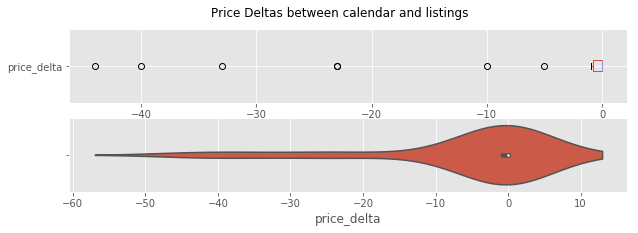

In [78]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 3))

plt.suptitle('Price Deltas between calendar and listings')
airbnb_evaluation.query("price_delta==price_delta").price_delta.plot.box(
    vert=False, ax=ax[0])

sns.violinplot(
    x='price_delta',
    data=airbnb_evaluation.query("price_delta==price_delta"),
    ax=ax[1])

plt.show()

## Differences between availability from Sample

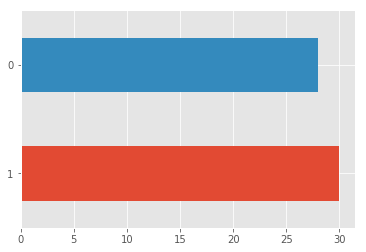

In [79]:
airbnb_evaluation.availability_match.value_counts().plot.barh();

## Testing Merge with rowsource and Geographical Columns

### First 5 Geo Rows from Sample

In [80]:
# Get only object columns
airbnb_evaluation_geo = airbnb_evaluation_merge.select_dtypes(include=object)

# The last 10 are sort of related to geography
airbnb_evaluation_geo = airbnb_evaluation_geo[airbnb_evaluation_geo.columns[-10:][:-6]]

airbnb_evaluation_geo.head()

,smart_location,space,state,street
0,"Boston, MA",Large living and dining area. Sprawling space....,MA,"Tyndale Street, Boston, MA 02131, United States"
1,"Boston, MA",Large living and dining area. Sprawling space....,MA,"Tyndale Street, Boston, MA 02131, United States"
2,"Boston, MA",Large living and dining area. Sprawling space....,MA,"Tyndale Street, Boston, MA 02131, United States"
3,"Boston, MA",Large living and dining area. Sprawling space....,MA,"Tyndale Street, Boston, MA 02131, United States"
4,"Boston, MA",Large living and dining area. Sprawling space....,MA,"Tyndale Street, Boston, MA 02131, United States"


### Geo Rows Aggrement with Rowsource from Sample

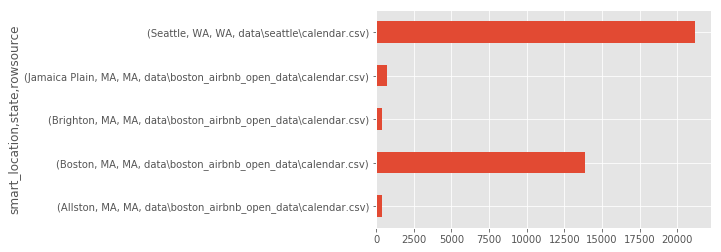

In [82]:
geo_columns = airbnb_evaluation_geo.columns.tolist() + ['rowsource']
geo_columns.remove('space')
geo_columns.remove('street')
airbnb_evaluation_merge[geo_columns].groupby(
    geo_columns).size().to_frame().plot.barh(legend=False);

## Looking for Meaningful Relationship Between Listing and Reivews

### Assessing Reviews and Ids from Sample

In [83]:
airbnb_evaluation_merge.filter(regex='revi|id').head().T

,0,1,2,3,4
listing_id,5434353,5434353,5434353,5434353,5434353
provided_flag,ProvidedValue,ProvidedValue,ProvidedValue,ProvidedValue,ProvidedValue
first_review,2015-09-01,2015-09-01,2015-09-01,2015-09-01,2015-09-01
host_id,9658771,9658771,9658771,9658771,9658771
host_identity_verified,t,t,t,t,t
id,5434353,5434353,5434353,5434353,5434353
last_review,2016-08-06,2016-08-06,2016-08-06,2016-08-06,2016-08-06
number_of_reviews,7,7,7,7,7
review_scores_accuracy,9,9,9,9,9
review_scores_checkin,10,10,10,10,10


### First 5 Comments

In [84]:
reviews.head()

,comments,date,id,listing_id,reviewer_id,reviewer_name,rowsource
0,My stay at islam's place was really cool! Good...,2013-05-21,4724140,1178162,4298113,Olivier,data\boston_airbnb_open_data\reviews.csv
1,Great location for both airport and city - gre...,2013-05-29,4869189,1178162,6452964,Charlotte,data\boston_airbnb_open_data\reviews.csv
2,We really enjoyed our stay at Islams house. Fr...,2013-06-06,5003196,1178162,6449554,Sebastian,data\boston_airbnb_open_data\reviews.csv
3,The room was nice and clean and so were the co...,2013-06-15,5150351,1178162,2215611,Marine,data\boston_airbnb_open_data\reviews.csv
4,Great location. Just 5 mins walk from the Airp...,2013-06-16,5171140,1178162,6848427,Andrew,data\boston_airbnb_open_data\reviews.csv


### Descriptive Statistics of Comments

In [85]:
comment_listing_counts = reviews.groupby('listing_id').size().to_frame(
    'comment_count').groupby('comment_count').size().reset_index().rename(
        columns={0: 'total_unique_listing_ids'})

comment_listing_counts[['comment_count']].describe()

,comment_count
count,229.000000
mean,127.720524
std,88.549820
min,1.000000
25%,58.000000
50%,115.000000
75%,180.000000
max,474.000000


### Unique Listing Id Comment Buckets

In [86]:
comment_listing_counts.groupby(
    pd.cut(comment_listing_counts.comment_count,
           bins=list(np.arange(0, 550, 50)))).sum()[[
               'total_unique_listing_ids'
           ]].reset_index().set_index('total_unique_listing_ids').rename(
               columns={'comment_count': 'comment_count_buckets'})

,comment_count_buckets
total_unique_listing_ids,
5157,"(0, 50]"
570,"(50, 100]"
167,"(100, 150]"
73,"(150, 200]"
28,"(200, 250]"
16,"(250, 300]"
4,"(300, 350]"
1,"(350, 400]"
2,"(400, 450]"


## Relationship between listings and calendar Datasets Results

We can see that there are some errors, but most of the bulk of the data is concentrated around zero. This means that we could use this method to impute missing prices. To assess which method is best, we are comparing this method to the method used later, which it will probably be median imputation.

However, we cannot assume that the missing availability in the listings agrees with the the availability in the calendar dataset. Indeed there are differences between the time when the calendar data was scraped and the time when the listings was scrapped for aggregates--maybe hours. Nevertheless, using the calendar availability will not be a viable method for imputation.

The datasets agree on the state and the source file name. Thus, this is the join that will be used for the final training and testing dataset.

The relationship between listing dataset reviews and reviews dataset comments is by the listing_id there are at most 474 reviews on at least one listing. Two listings have around 451 to 474 comments. However, the majority of the listings have 1 to 50 comments.

The join for the final dataset is as follows:
* listing_id on calendar
* id on listings
* inner join on calendar side

# Preparing Data for Analysis

In [91]:
# column additions for scatter and monthly comparisons
calendar_clean.loc[:, 'date_num'] = calendar_clean.date.rank(method='dense')
month_name_func = lambda x: '0'+str(x.month)[-2:] + '-' + x.month_name()
calendar_clean.loc[:, 'month_name'] = calendar_clean.date.apply(month_name_func)

## Calendar Removals or Imputations

###  Assessing Calendar Removal Impact

In [92]:
calendar_missing = calendar_clean.groupby('provided_flag').size().to_frame('row_count')\
        .assign(pct_total=lambda x: x.row_count/x.row_count.sum()*100)
calendar_missing

,row_count,pct_total
provided_flag,,
MissingValue,1124596,41.61941
ProvidedValue,1577499,58.38059


### Removal Percentages by Data Source

In [93]:
calendar_rowsource_miss = calendar_clean.groupby(
    ['rowsource', 'provided_flag']).size().to_frame('row_count').assign(
        pct_total=lambda x: x.row_count / x.row_count.sum() * 100)

calendar_rowsource_miss

row_count  pct_total
rowsource                                 provided_flag                      
data\boston_airbnb_open_data\calendar.csv MissingValue      665568  24.631554
                                          ProvidedValue     642957  23.794759
data\seattle\calendar.csv                 MissingValue      459028  16.987856
                                          ProvidedValue     934542  34.585831

### Removals by Month

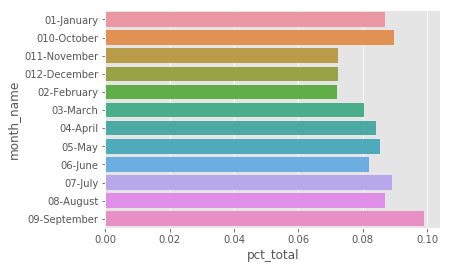

In [95]:
calendar_month_miss = calendar_clean.query("provided_flag=='MissingValue'").groupby(
    ['month_name', 'provided_flag']).size().to_frame('row_count').assign(
        pct_total=lambda x: x.row_count / x.row_count.sum())

sns.barplot(
    x='pct_total', y='month_name', data=calendar_month_miss.reset_index());

### Price Distributions by Month, RowSource, Dates

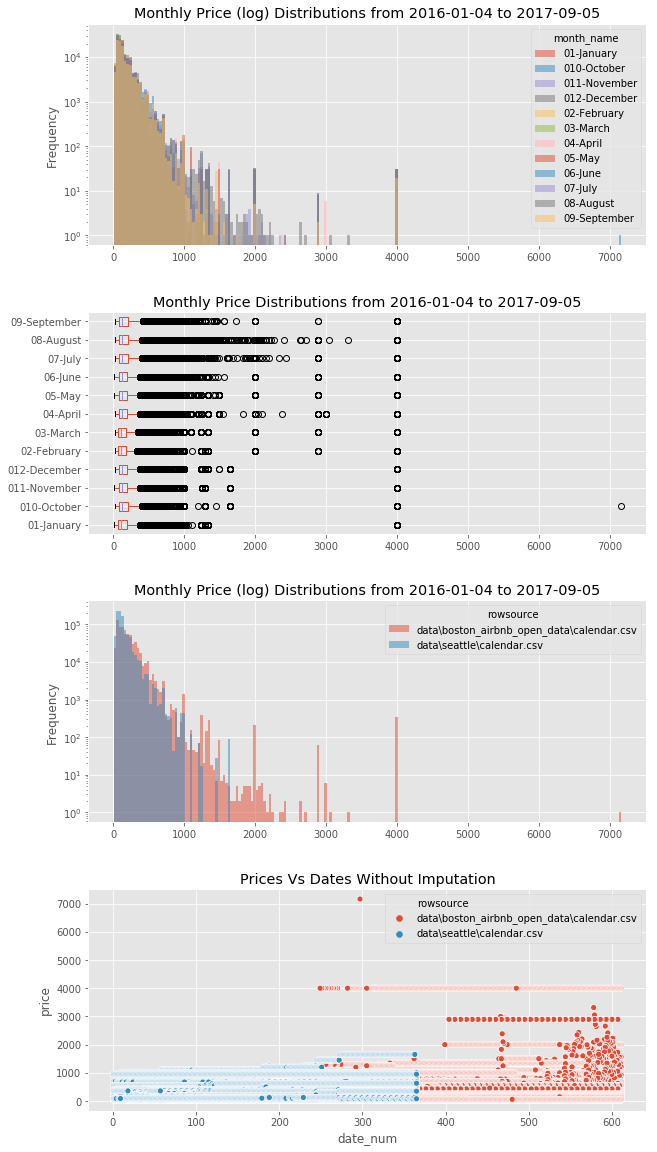

In [96]:
# Dataset groupings
calendar_price_bymonth = calendar_clean.reset_index(drop=True).pivot(
    columns='month_name', values='price')

calendar_price_bysource = calendar_clean.reset_index(drop=True)\
    .pivot(columns='rowsource', values='price')

# Title min max dates
max_date = str(calendar_clean.date.max().date())
min_date = str(calendar_clean.date.min().date())

# Starting subplot
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(10, 20))

plt.subplots_adjust(hspace=.3)

calendar_price_bymonth.plot.hist(
    bins=200,
    logy=True,
    alpha=.5,
    title=f'Monthly Price (log) Distributions from {min_date} to {max_date}',
    ax=ax[0])

calendar_price_bymonth.plot.box(
    vert=False,
    title=f'Monthly Price Distributions from {min_date} to {max_date}',
    ax=ax[1])

calendar_price_bysource.plot.hist(
    bins=200,
    logy=True,
    alpha=.5,
    title=f'Monthly Price (log) Distributions from {min_date} to {max_date}', ax=ax[2])

plt.title('Prices Vs Dates Without Imputation')
sns.scatterplot(x='date_num', 
                y='price', 
                hue='rowsource', 
                data=calendar_clean, ax=ax[3])

plt.show()

### Calendar Removal or Imputation Results

> **Price Imputation Decision**: 
* Given that the prices are skew to the left, the imputation approach will be the median method on a daily basis, which is not influenced by outliers.
* Given that we were going to remove 42% of the data because of Null prices, I am attempting to mitigate the loss of information by imputing the median on a daily basis, but I am leaving a category for those values that were imputated for the model to recognize those. Perhaps it will be beneficial.
* Another idea is to pass a test set that was not imputated to see if the imputation caused overfitting. I will be able to know what was imputated by looking at the imputed_price column.

# Listings Null Analysis
---

#### Listings Columns With Nulls

In [64]:
# recalling columns with nulls from previous null analysis
listing_null_columns = list(listing_nulls.index.drop('license'))
print(listing_null_columns)

['host_listings_count', 'city', 'host_total_listings_count', 'host_thumbnail_url', 'host_since', 'host_picture_url', 'host_has_profile_pic', 'host_identity_verified', 'host_is_superhost', 'host_name', 'property_type', 'beds', 'market', 'bedrooms', 'host_location', 'bathrooms', 'zipcode', 'summary', 'host_neighbourhood', 'thumbnail_url', 'medium_url', 'xl_picture_url', 'neighbourhood', 'host_response_rate', 'host_response_time', 'host_acceptance_rate', 'reviews_per_month', 'last_review', 'first_review', 'review_scores_rating', 'review_scores_communication', 'review_scores_cleanliness', 'review_scores_location', 'review_scores_value', 'review_scores_checkin', 'review_scores_accuracy', 'space', 'cleaning_fee', 'host_about', 'transit', 'neighborhood_overview', 'notes', 'has_availability', 'jurisdiction_names', 'neighbourhood_group_cleansed', 'security_deposit', 'weekly_price', 'monthly_price', 'house_rules', 'access', 'interaction', 'square_feet']


#### Dropping Listings Columns With all Nulls

In [65]:
listings.dropna(how='all', axis=1, inplace=True)

#### Listings Null Analysis

In [66]:
t_columns = listings.shape[1]
h_columns = listings.isnull().sum(axis=1)
listings.loc[:, 'row_null_pct'] = h_columns/t_columns

In [67]:
def listing_dist(df, bins, title):
    upper_func = lambda x: x.state.str.upper()
    df.assign(state=upper_func)[['state', 'row_null_pct']]\
        .reset_index()\
        .pivot(index='index',
              columns='state',
              values='row_null_pct')\
        .plot.hist(alpha=.5, 
                   bins=bins,
                   figsize=(12, 5),
                   title=title);

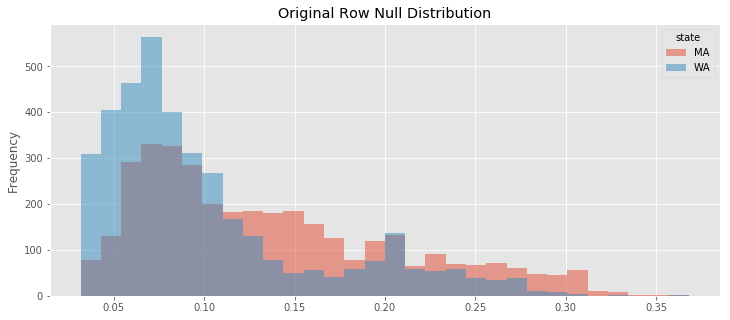

In [68]:
listing_dist(listings, 30, 'Original Row Null Distribution')               

> **Row Null Removal Decision**:
  * Will remove any row that contains more than 30 % of null values
  * Will attempt to imputate anything with less than 30 % of null values
  * What we cannot imputate will be feeded to the model as null dummies

#### Removal of Listings Dataset Rows

In [ ]:
# removal threshold
row_remove = listings.row_null_pct <= .50

# removing rows
listings_row_clean = listings[row_remove]

> **Row Null Removal Results**
* The distribution of null still looks skew. But it is better than before.
* The next step is imputations of null values to see if we can make this distribution look more normal.

### Identifying Irrelevant Columns

In [ ]:
# target colmuns for imputations and transformations
target_columns = listings_row_clean.isnull().sum().where(lambda x: x>0).dropna().index.tolist()
target_columns

### Creating a Tracker of Features

In [ ]:
predictors = []
possible = []
dummies = []
irrelevant = []
all_assessed = []
engineered = []

def tracker_add(track_type=None, features=[], assessed=False):
    """
    To keep track of features
    """
    global predictors, possible, dummies, irrelevant, all_assessed, engineered
    
    # Pass features to trackers and clean duplicates
    def pass_and_clean(feature_holder):
        [feature_holder.append(x) for x in features]
        feature_holder = list(dict.fromkeys(feature_holder))
        return feature_holder
    
    if track_type == 'predictors':
        predictors = pass_and_clean(predictors)
    elif track_type == 'dummies':
        dummies = pass_and_clean(dummies)
    elif track_type == 'possible':
        possible = pass_and_clean(possible)
    elif track_type == 'irrelevant':
        irrelevant = pass_and_clean(irrelevant)
    elif track_type == 'engineered':
        engineered = pass_and_clean(engineered)
    else:
        print("Nothing added :(")
        
    # Add if the feature was analyzed
    if assessed:
        all_assessed = pass_and_clean(all_assessed)
        
def tracker_check():
    # All trackers
    tracker_list = [all_assessed, predictors, engineered, possible, 
                    dummies, irrelevant]
    
    tracker_names = ['all_assessed', 'predictors', 'engineered', 'possible', 
                     'dummies', 'irrelevant']
    # Empty dataframe
    df = pd.DataFrame()
    
    # Create dataframe of trackers by columns
    for tracker, name in list(zip(tracker_list, tracker_names)):
        
        # Create tracker columns df
        df_col = pd.DataFrame(tracker, columns=[name])
        
        # Combine trackers in df
        df = pd.concat([df, df_col], axis=1)
        
    return df

### Columns to Remove due to Irrelevance

In [ ]:
irrelevant_columns = listings_row_clean.columns.str.contains('url|pic|name|about|cleansed')
irrelevant_columns = listings_row_clean.columns[irrelevant_columns].tolist()
tracker_add('irrelevant', irrelevant_columns)

In [ ]:
listings_row_clean[irrelevant_columns].head(1).T.style.set_caption("Irrelevant Features")

These, above, are irrelevant columns. They describe web addresses, names and pictures. They will add no value to the model. Perhaps host_has_profile_pic and require_guest_profile_picture will add value to the model but we can add them later if the model is not performing well. **possible_predictors** will keep track of the features that could add some values to the model.

In [ ]:
features = ['host_has_profile_pic', 'require_guest_profile_picture']
tracker_add('possible', features)

### Colums to Engineer Provided Info (1) or Not Provided (0)

In [ ]:
interest = ['']
iform_arguments = 'access|over|rule|notes|space|summary|transit|interaction'
df_info = listings_row_clean.filter(regex=iform_arguments)
inform_columns = df_info.columns.tolist()
df_info.head()

In [ ]:
tracker_add('predictors', inform_columns)

### Columns Left to Imputate or to Engineer

In [ ]:
target_columns = [x for x in target_columns if x not in tracker_check().irrelevant.tolist()]
target_columns

In [ ]:
listings_row_clean[target_columns].sample(2).T

## Transformations and Imputations

In [ ]:
def correlation_status(column_list):
    """
    Plotting the correlations to keep track of multicollinearity and corrlation with price.
    """
    col_interest = ['id'] + column_list
    price_corr = calendar[['listing_id', 'price']]\
    .merge(listings_row_clean[col_interest],
          left_on='listing_id',
          right_on='id',
          how='left')\
    .drop(['id', 'listing_id'], axis=1)\
    .query("price==price")\
    .astype(float)\
    .corr()
    
    plt.figure(figsize=(14, 10))

    sns.heatmap(price_corr, annot=True, cmap='magma');

### <li> Informational Columns

These informational columns have information about how to access the palce, house rules, interactions with host, etc. Thus, they migh be useful to predict price taking in consideration if some sort of information was provided. Therefore we are converting where information is provided to a 1 and where not provided to 0. There will be no connection back to the test. It will just indicate that information about the column was provided.

In [ ]:
inform_columns

####  <ol> Imputing Access as AccessInfoProvided

In [ ]:
# Conducting Transformations and Imputations
provided_func = lambda x: x.isnull()
inform_transform = listings_row_clean[inform_columns].where(provided_func, 1).fillna(0)

In [ ]:
# creating the new column for provided access information
listings_row_clean.loc[:, inform_columns] = inform_transform

In [ ]:
# Example of transformation results
listings_row_clean.loc[:, inform_columns].sample(10)

In [ ]:
correlation_status(inform_columns)

In [ ]:
tracker_add('dummies', inform_columns, assessed=True)

These informational columns are not substantially correlated with price. For this reason, they will be removed from the dataset, with the exception of house_rules or interaction. They have the bigest correlation with price. However, they are also heavily correlated with eachother. For this reason, we are going to pick just house_rules because it has the highest correlation with price. In the end, it is going to be just a close call for the feature since if the model is performing well without it, we will remove it. We are adding it to the **predictors**, which will keep track of the features that will be initially used in the model.

In [ ]:
tracker_check()

### <li> Number of Bathrooms, Bedrooms, and Beds

In [ ]:
def target_top5():
    filter_features = tracker_check().all_assessed.tolist()
    print([col for col in target_columns if col not in filter_features][:5])

In [ ]:
target_top5()

In [ ]:
bathroom_to_impute = listings_row_clean.groupby('bedrooms').bathrooms
bathroom_to_impute = bathroom_to_impute.apply(lambda x: x.mode()).to_frame()
bathroom_to_impute

In [ ]:
# for listings with 6 bedrooms imput 3 bathrooms
keep = bathroom_to_impute.reset_index().level_1 == 0
bathroom_to_impute = bathroom_to_impute.reset_index()[keep].drop('level_1', axis=1)
bathroom_to_impute

In [ ]:
bathroom_map = bathroom_to_impute.set_index('bedrooms').T.to_dict('records')[0]

In [ ]:
# missing bedrooms counts that have null values
listings_row_clean.query("bathrooms!=bathrooms")\
    .groupby('bedrooms')\
    .size()\
    .to_frame('couts')

In [ ]:
bedrooms_to_impute = listings_row_clean.groupby('bathrooms').bedrooms
bedrooms_to_impute = bedrooms_to_impute.apply(lambda x: x.mode()).to_frame()
bedrooms_to_impute.reset_index().drop('level_1', axis=1)

In [ ]:
# missing bathroom counts that have null values
listings_row_clean.query("bedrooms!=bedrooms")\
    .groupby('bathrooms')\
    .size()\
    .to_frame('couts')

In [ ]:
beds_to_impute = listings_row_clean.groupby(['bedrooms']).beds
beds_to_impute = beds_to_impute.apply(lambda x: x.mode()).to_frame()
beds_to_impute.reset_index().drop('level_1', axis=1)

In [ ]:
# missing beds counts that have null values
listings_row_clean.query("beds!=beds")\
    .groupby('bedrooms')\
    .size()\
    .to_frame('couts')

#### <ol> Imputing Mode of Bedrooms and Bathrooms

In [ ]:
# imputing bathrooms
listings_row_clean.loc[:, 'bathrooms'] = listings_row_clean.loc[:, 'bathrooms'].fillna(1)

# imputing bedrooms
listings_row_clean.loc[:, 'bedrooms'] = listings_row_clean.loc[:, 'bedrooms'].fillna(1)

# imputing beds
listings_row_clean.loc[:, 'beds'] = listings_row_clean.loc[:, 'beds'].fillna(1)

In [ ]:
correlation_status(['bathrooms', 'bedrooms', 'beds'])

In [ ]:
tracker_add('predictors', ['bathrooms', 'bedrooms', 'beds'], assessed=True)

In this case the correlation between price and bedrooms, bathrooms, or beds is moderate. Bedrooms has the highest correlation with price followed by beds and bathrooms. However, beds and bedrooms are correlated to eachother. Thus, we will have to pick one. Bedrooms have the biggest correlation so bedrooms and bathrooms will be choosen to predict price. So bedrooms and bathrooms will be added to the **predictors**.

 **Bedroom, Bathroom, Beds Imputing Decission**:
* The mode bathrooms grouped by bedrooms is going to be imputed for the bathrooms.
* The mode bedrooms grouped by bathrooms is going to be imputed for the bedrooms.
* The mode beds grouped by bedrooms is going to be imputed for the beds.

In [ ]:
tracker_check()

### <li> City

In [ ]:
# Target columns left
target_top5()

In [ ]:
city_related_col = ['city', 'zipcode', 'latitude', 'longitude', 'neighbourhood',
                    'street', 'smart_location']
listings_row_clean[city_related_col].query("city!=city")

#### <ol> Imputing city

In [ ]:
# Imputing chestnut hill
listings_row_clean.loc[:, 'city'] = listings_row_clean.loc[:, 'city'].fillna('Chestnut Hill')

In [ ]:
# Checking sparsity
listings_row_clean.city.value_counts().plot.barh(figsize=(10, 10));

In [ ]:
# Fixing sparsity issue
eng_group_bos = {True:'Boston'}
eng_group_sea = {True:'Seattle'}
eng_group_city = lambda x: x.str.contains('Boston|Seattle')

# Grouping Seattle Areas
fill_sea = listings_row_clean.city.str.contains('seattle', case=False)\
    .map(eng_group_sea)

# Grouping Boston Areas
fill_bos = listings_row_clean.city.str.contains('boston', case=False)\
    .map(eng_group_bos)

# Grouping Other Areas
group_sparse = fill_bos.fillna(fill_sea).where(eng_group_city, 'Other')

# Applying sparcity fix to city
listings_row_clean.loc[:, 'city'] = group_sparse

In [ ]:
# Checking sparsity
(listings_row_clean.city.value_counts()/listings_row_clean.city.count())\
    .to_frame().style.format("{:2.2%}")

In [ ]:
# Vectorizing the cities
city_vectorized = pd.get_dummies(listings_row_clean[['city']])

# Adding vectorization to listings
listings_row_clean = pd.concat([listings_row_clean.drop('city', axis=1), 
                                city_vectorized], axis=1)

In [ ]:
correlation_status(city_vectorized.columns.tolist())

In [ ]:
tracker_add('dummies', ['city'], assessed=True)

At first, this was a Null issue that could be solved by imputations. However, after investigating the sparsity of the data, some cities had low sample counts. These cities with low sparsity counts were grouped into a category called Other. Thus, city now represents Seattle, Boston, and Other as dummy features. Other still show signs of sparsity since it only accounts for 2.51% of the counts. Perhaps this is the reason why the correlation of Other is not as high as Boston and Seattle. Nevertheless, the correlation is low but significant. All dummy features will be tracked using **dummies**.

**City Imputation Decission**:
* Given by the related latitude and longitude, both missing values are related to Chestnut Hill city in Massachusets.
* Cities where grouped and vectorized as mentioned in the above paragraph.

In [ ]:
tracker_check()

### <li> Cleaning Fee

In [ ]:
# Target columns left
target_top5()

#### <ol> Investigating Cleaning Fee Null Relations

In [ ]:
listings_row_clean.cleaning_fee[:10]

#### <ol> Cleaning Cleaning Fee

In [ ]:
clefee_func = lambda x: x.replace('$', '') if not pd.isnull(x) else x
listings_row_clean.loc[:, 'cleaning_fee'] = listings_row_clean\
    .cleaning_fee\
    .apply(clefee_func)\
    .astype(float)

#### <ol> Checking Importance of Cleaning Fee

In [ ]:
listings_row_clean.cleaning_fee\
    .plot.hist(bins=25, 
               title='Cleaning Fee Distribution',
               cmap='Set2');

In [ ]:
min_clea = listings_row_clean.cleaning_fee.min()
max_clea = listings_row_clean.cleaning_fee.max()
mid_clea = (max_clea - min_clea)/2
grouper = pd.cut(listings_row_clean.cleaning_fee, bins=[min_clea, mid_clea, max_clea])
listings_row_clean.groupby(grouper).size().to_frame('counts')

#### <ol> Imputing Cleaning Fee

In [ ]:
# We are assuming that null fees are zero fees
listings_row_clean.loc[:, 'cleaning_fee'] = listings_row_clean\
    .cleaning_fee.fillna(0)

In [ ]:
correlation_status(['cleaning_fee'])

In [ ]:
tracker_add('predictors', ['cleaning_fee'], assessed=True)

We can see that cleaning fee is moderately correlated with price. So we are going to add this one to the predictors. We have assumed that nulls are representing no fee and therefore it is set to 0. The minimun fee is 5 dollars. 

> **Cleaning Fee Imputation Decision**:
* Since there is no 0 fees recorded, we are assuming the null values indicates where the listing has no cleaning fee.

In [ ]:
tracker_check()

### <li> First Review, Last Review

In [ ]:
# Columns related to reviews
review_columns = listings_row_clean.columns[listings_row_clean.columns.str.contains('review')]
review_columns = ['id'] + review_columns.tolist()

df_review_columns = listings_row_clean[review_columns]

#### <ol> Investigating Null Values

In [ ]:
df_review_columns.query("number_of_reviews!=0").isnull().sum().to_frame('missing')\
    .style.set_caption('Where Number of Reviews is not 0.')

In [ ]:
df_review_columns.query("number_of_reviews==0").isnull().sum().to_frame('missing')\
    .style.set_caption('Where Number of Reviews is 0')

In [ ]:
df_review_columns.query("number_of_reviews!=0")\
    .merge(reviews.groupby('listing_id', as_index=False).sum(),
           left_on='id',
           right_on='listing_id',
           how='left',
           suffixes=['', '_reviews']).isnull().sum().to_frame('missing')\
    .style.set_caption('Where Number of Reviews not 0 and merge reviews')

In [ ]:
df_review_columns.head()

> **Reviews imputations decission**:
* Where the  number of reviews is 0, all review data is Null. This means that these Nulls are meaningfull for the analysis and should be set as dummies to identify when listings have no ratings.
* Where the number of reviews is not 0, there are some review scores that are null. However, the revies dataset fills these nulls.
* Given that the reviews dataset, we could apply natural language processing to predict the missing ratings.
* Since there are no substantial missing values for these scores, we are leaving the nulls for now. We can later apply NLP to predict them if the predicting model does not perform as desired.
* We are removing first_review and last_review and replacing it with review_lag to account for the dates between the first review and the last review.
* Another option is to engineer the rate of reviews by dividing the review_lag by the number_of_reviews. We are doing the column here, but if it perform worst than the two derived columns, we will drop it.

#### <ol> Engineering review_lag and review_rate

In [ ]:
# creating the lag between first and last review
day_func = lambda x: x.days
diff_func = lambda x: (pd.to_datetime(x.last_review) - pd.to_datetime(x.first_review)).apply(day_func)
reate_func = lambda x: (x.review_lag/x.number_of_reviews)

# engineering review lag
listings_row_clean = listings_row_clean.assign(review_lag=diff_func)

# engineering review rate
listings_row_clean = listings_row_clean.assign(review_rate=reate_func)

# dropping fist_review and last_review
review_dates = ['first_review', 'last_review']
listings_row_clean.drop(review_dates, axis=1, inplace=True)

In [ ]:
correlation_columns = ['review_lag', 'review_rate', 'number_of_reviews']
correlation_status(correlation_columns)

In [ ]:
tracker_add('irrelevant', review_dates, assessed=True)
tracker_add('engineered', ['review_lag', 'review_rate'])

We can see that the only valuable engineered feature is the review rate. The review lag is insignificant. And the initial feature number of reviews is insignificant by itself. The review rate at least has a low significance with price. 

**Engeniering Decission**:
* For the lag, we substracted the frist review date from the last review date.
* For the review rate, we divided the review lag by the number of reviews, which give us the rate of reviews between the first review date and the last review date.

In [ ]:
tracker_check()

### <li> Has availability

In [ ]:
target_top5()

In [ ]:
grouping = ['has_availability', 'property_type', 'room_type']
highlight = lambda x: 'background-color: orange' if x == 'missing' else ''
listings_row_clean.fillna('missing').groupby(grouping).size()\
    .to_frame('listing_count').reset_index()\
    .query("listing_count > 10")\
    .style.applymap(highlight).bar(color='green')

**has_availability imputation decission**:
It seems that the distributions between availability and missing values agree within property types and room types. The missing values do not appear to be random. Therefore, we can assume that these missing values indicate unavailability. For this reason, we are going to imputate a 0 for missing and 1 for availability (t).

In [ ]:
imputation = listings_row_clean.has_availability.map({'t':1}).fillna(0)
listings_row_clean.loc[:, 'has_availability'] = imputation

In [ ]:
correlation_status(['has_availability'])

**Correlation status**:

### <li> Preparing Data for Analysis: Starting Calendar Imputations

In [ ]:
calendar_imputed = calendar.copy()

#### Null Price Imputations

In [ ]:
filter_bos_cond = (calendar.rowsource == 'data\\boston_airbnb_open_data\\calendar.csv')
filter_sea_cond = (calendar.rowsource == 'data\\seattle\\calendar.csv')

##### <ol> Boston Imputation

In [ ]:
calendar[filter_bos_cond].query("date == '2017-09-05'").price.describe()

In [ ]:
# daily medians to impute for boston
bos_medians = calendar[filter_bos_cond].groupby(['rowsource', 'date']).price.transform('median')

In [ ]:
# boston price imputation
calendar_imputed.loc[filter_bos_cond, 'price'] = calendar[filter_bos_cond].price.fillna(bos_medians)

In [ ]:
# Validating imputation
calendar_imputed.query("date=='2017-09-05' and nan_grp=='MissingValue'").head(1)

##### <ol> Seattle Imputation

In [ ]:
calendar[filter_sea_cond].query("date == '2016-09-05'").price.describe()

In [ ]:
# daily medians to impute for boston
sea_medians = calendar[filter_sea_cond].groupby(['rowsource', 'date']).price.transform('median')

# boston price imputation
calendar_imputed.loc[filter_sea_cond, 'price'] = calendar[filter_sea_cond].price.fillna(sea_medians)

In [ ]:
# Validating imputation
calendar_imputed.query("date=='2016-09-05' and nan_grp=='MissingValue'").head(1)

##### <ol> imputed_price Category

In [ ]:
# mapping the labels for the imputed_price category
imputed_price = {'MissingValue': 1, 'ProvidedValue': 0}

# creating category
calendar_imputed['imputed_price'] = calendar_imputed.nan_grp.map(imputed_price)

In [ ]:
# validating imputed_price category
calendar_imputed.query("imputed_price==1").nan_grp.unique()

In [ ]:
# dropping nan_grp and other unecessary columns
drop_from_calendar = ['rowsource', 'nan_grp', 'source_grp']
calendar_imputed.drop(drop_from_calendar, axis=1, inplace=True)

In [ ]:
calendar_imputed.head()

# Analysis & Visualizations

# Modeling & Visualizations

# Evaluating Results

# Conclussion

In [ ]:
sns.scatterplot

In [ ]:
os.system("git add .")

In [ ]:
os.system('git commit -m "Feature engineering first review to last review days"')

In [ ]:
os.system("git push")